In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA





In [2]:
pip install prophet

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('NYC_Energy_Consumption.csv')

# Display the first few rows
print(data.head())

# Get a summary of the dataset
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Describe the data to understand its statistical properties
print(data.describe())

   Unnamed: 0      TxnDate   TxnTime  Consumption
0       76229  01 Jan 2022  16:55:52        1.010
1       76258  01 Jan 2022  21:45:29        0.908
2       76287  01 Jan 2022  12:24:52        0.926
3       76316  01 Jan 2022  04:07:36        0.928
4       76345  01 Jan 2022  06:52:25        0.916
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1228 non-null   int64  
 1   TxnDate      1228 non-null   object 
 2   TxnTime      1228 non-null   object 
 3   Consumption  1228 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 38.5+ KB
None
Unnamed: 0     0
TxnDate        0
TxnTime        0
Consumption    0
dtype: int64
         Unnamed: 0  Consumption
count   1228.000000  1228.000000
mean   85021.511401     3.428194
std     6275.942563     3.535620
min    73596.000000     0.842000
25%    78825.750000     0.95

In [4]:
# Convert 'TxnDate' to datetime format and create a new datetime column 'ds'
data['ds'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'])

# Drop the original 'TxnDate' and 'TxnTime' columns
data = data.drop(columns=['TxnDate', 'TxnTime'])

# Check the cleaned data
print(data.head())

   Unnamed: 0  Consumption                  ds
0       76229        1.010 2022-01-01 16:55:52
1       76258        0.908 2022-01-01 21:45:29
2       76287        0.926 2022-01-01 12:24:52
3       76316        0.928 2022-01-01 04:07:36
4       76345        0.916 2022-01-01 06:52:25


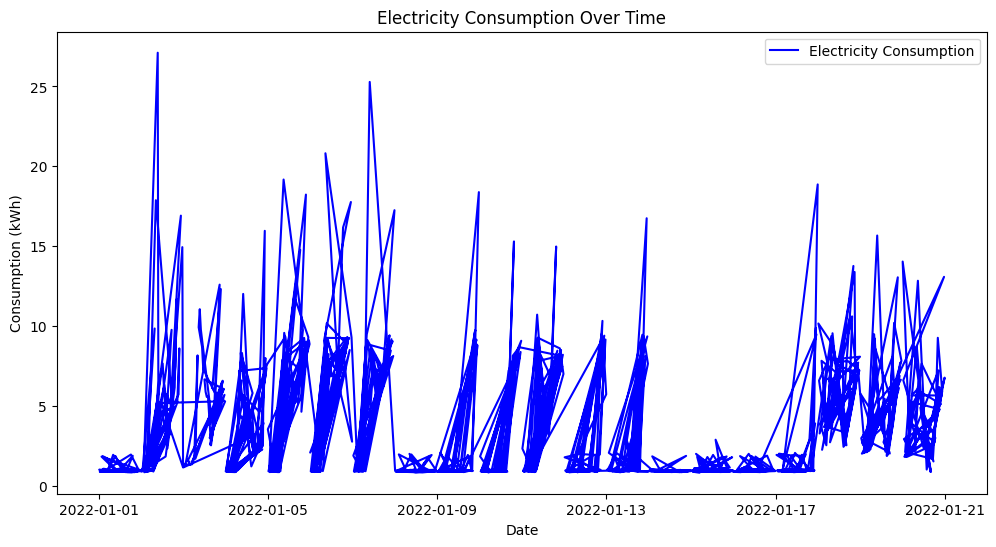

In [5]:
# Set the date as the index for easier plotting
data.set_index('ds', inplace=True)

# Plot the consumption over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Consumption'], label='Electricity Consumption', color='blue')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

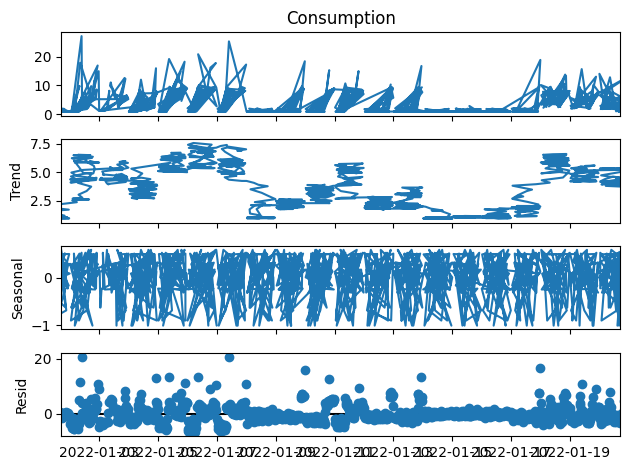

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(data['Consumption'], model='additive', period=24)  # Assuming hourly data
fig = decomposition.plot()
plt.show()

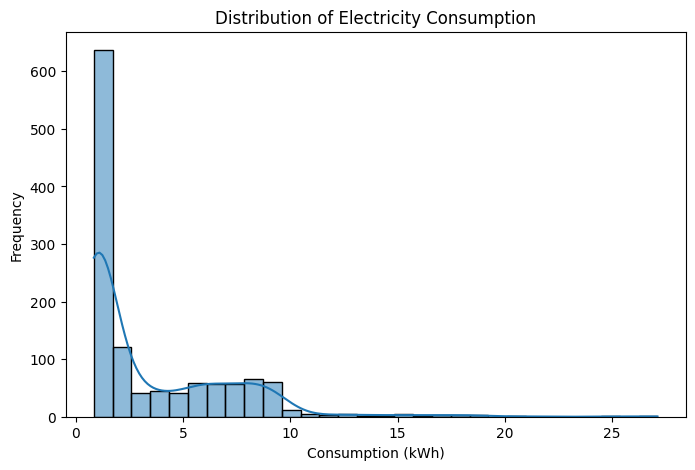

In [7]:
# Plot the distribution of consumption
plt.figure(figsize=(8, 5))
sns.histplot(data['Consumption'], bins=30, kde=True)
plt.title('Distribution of Electricity Consumption')
plt.xlabel('Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Reset index to access 'ds' column
data.reset_index(inplace=True)

# Extract additional time-related features
data['Year'] = data['ds'].dt.year
data['Month'] = data['ds'].dt.month
data['Day'] = data['ds'].dt.day
data['Weekday'] = data['ds'].dt.weekday
data['Weekend'] = data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Check the updated data
print(data.head())

                   ds  Unnamed: 0  Consumption  Year  Month  Day  Weekday  \
0 2022-01-01 16:55:52       76229        1.010  2022      1    1        5   
1 2022-01-01 21:45:29       76258        0.908  2022      1    1        5   
2 2022-01-01 12:24:52       76287        0.926  2022      1    1        5   
3 2022-01-01 04:07:36       76316        0.928  2022      1    1        5   
4 2022-01-01 06:52:25       76345        0.916  2022      1    1        5   

   Weekend  
0        1  
1        1  
2        1  
3        1  
4        1  


In [9]:
# Example holiday list (you may want to expand this)
holidays = {
    '2022-01-01',  # New Year's Day
    '2022-07-04',  # Independence Day
    '2022-12-25',  # Christmas
}

# Create a binary holiday column
data['Holiday'] = data['ds'].dt.date.isin(holidays).astype(int)

# Check the updated data
print(data.head())

                   ds  Unnamed: 0  Consumption  Year  Month  Day  Weekday  \
0 2022-01-01 16:55:52       76229        1.010  2022      1    1        5   
1 2022-01-01 21:45:29       76258        0.908  2022      1    1        5   
2 2022-01-01 12:24:52       76287        0.926  2022      1    1        5   
3 2022-01-01 04:07:36       76316        0.928  2022      1    1        5   
4 2022-01-01 06:52:25       76345        0.916  2022      1    1        5   

   Weekend  Holiday  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4        1        0  


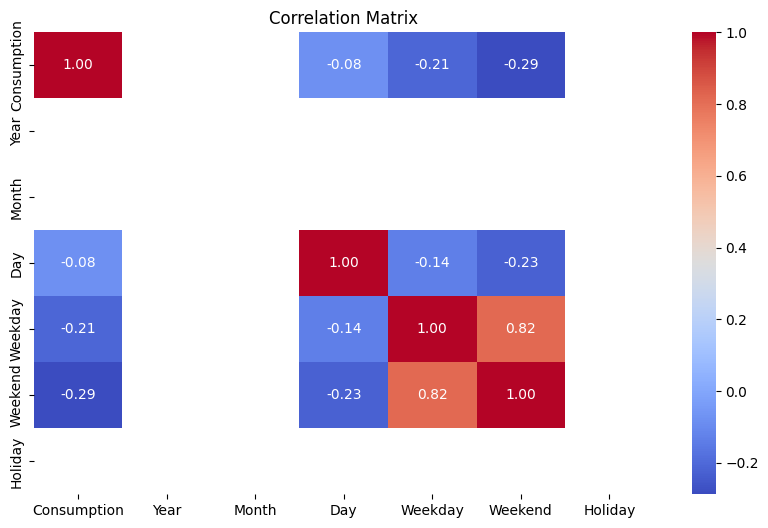

In [10]:
# Calculate correlations
correlation_matrix = data[['Consumption', 'Year', 'Month', 'Day', 'Weekday', 'Weekend', 'Holiday']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# Prepare the final DataFrame for Prophet
final_data = data[['ds', 'Consumption', 'Weekend', 'Holiday']].rename(columns={'Consumption': 'y'})

# Check the final data frame
print(final_data.head())

                   ds      y  Weekend  Holiday
0 2022-01-01 16:55:52  1.010        1        0
1 2022-01-01 21:45:29  0.908        1        0
2 2022-01-01 12:24:52  0.926        1        0
3 2022-01-01 04:07:36  0.928        1        0
4 2022-01-01 06:52:25  0.916        1        0


   Unnamed: 0      TxnDate   TxnTime  Consumption
0       76229  01 Jan 2022  16:55:52        1.010
1       76258  01 Jan 2022  21:45:29        0.908
2       76287  01 Jan 2022  12:24:52        0.926
3       76316  01 Jan 2022  04:07:36        0.928
4       76345  01 Jan 2022  06:52:25        0.916
                   ds      y
0 2022-01-01 16:55:52  1.010
1 2022-01-01 21:45:29  0.908
2 2022-01-01 12:24:52  0.926
3 2022-01-01 04:07:36  0.928
4 2022-01-01 06:52:25  0.916
                   ds      y
0 2022-01-01 16:55:52  1.010
1 2022-01-01 21:45:29  0.908
2 2022-01-01 12:24:52  0.926
3 2022-01-01 04:07:36  0.928
4 2022-01-01 06:52:25  0.916
ds    0
y     0
dtype: int64


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5e74j5pf/z58tmujf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5e74j5pf/v7o3_et9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34693', 'data', 'file=/tmp/tmp5e74j5pf/z58tmujf.json', 'init=/tmp/tmp5e74j5pf/v7o3_et9.json', 'output', 'file=/tmp/tmp5e74j5pf/prophet_modeliwok9df0/prophet_model-20241107182409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


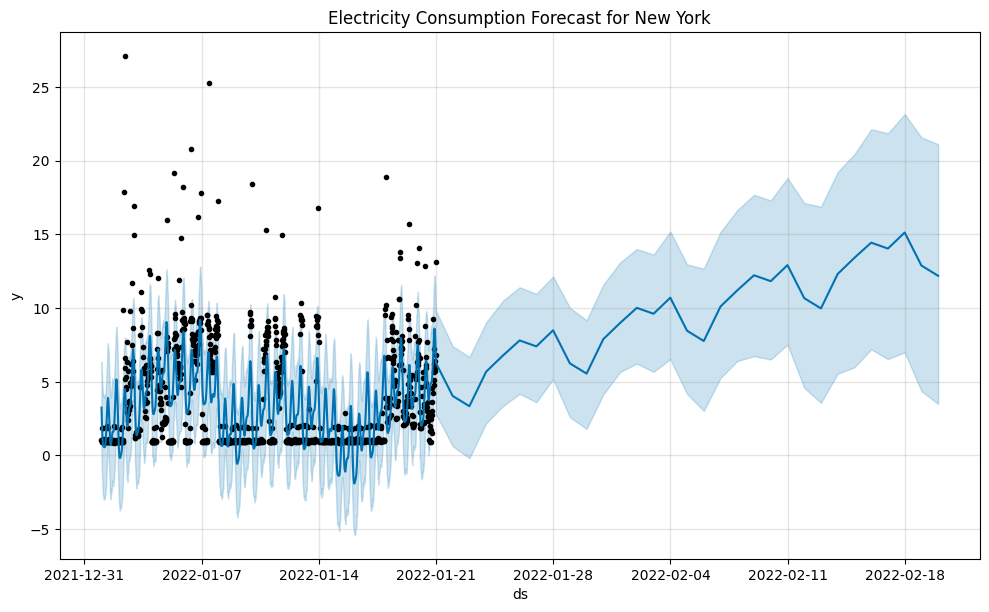

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5e74j5pf/rbm32czx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5e74j5pf/9yy1vs02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96463', 'data', 'file=/tmp/tmp5e74j5pf/rbm32czx.json', 'init=/tmp/tmp5e74j5pf/9yy1vs02.json', 'output', 'file=/tmp/tmp5e74j5pf/prophet_modelkfvnebgk/prophet_model-20241107182410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error: 3.714683694358692
Mean Squared Error: 24.025373178725477


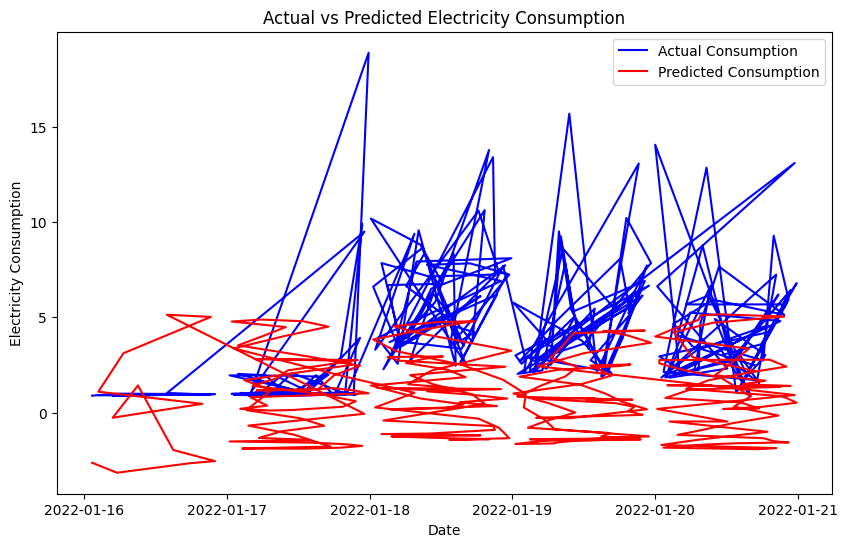

                      ds       yhat  yhat_lower  yhat_upper
1222 2022-01-21 23:47:55   4.031947    0.620818    7.411811
1223 2022-01-22 23:47:55   3.334564   -0.194603    6.677428
1224 2022-01-23 23:47:55   5.676134    2.182289    9.023953
1225 2022-01-24 23:47:55   6.770583    3.339607   10.490449
1226 2022-01-25 23:47:55   7.797798    4.175103   11.407598
1227 2022-01-26 23:47:55   7.396137    3.605476   10.962074
1228 2022-01-27 23:47:55   8.487008    5.169427   12.136398
1229 2022-01-28 23:47:55   6.244303    2.586178   10.019447
1230 2022-01-29 23:47:55   5.546920    1.795474    9.165864
1231 2022-01-30 23:47:55   7.888489    4.136020   11.583595
1232 2022-01-31 23:47:55   8.982938    5.655336   13.092016
1233 2022-02-01 23:47:55  10.010153    6.226088   14.005308
1234 2022-02-02 23:47:55   9.608492    5.668115   13.619195
1235 2022-02-03 23:47:55  10.699364    6.527863   15.188760
1236 2022-02-04 23:47:55   8.456658    4.164901   12.958355
1237 2022-02-05 23:47:55   7.759275    3

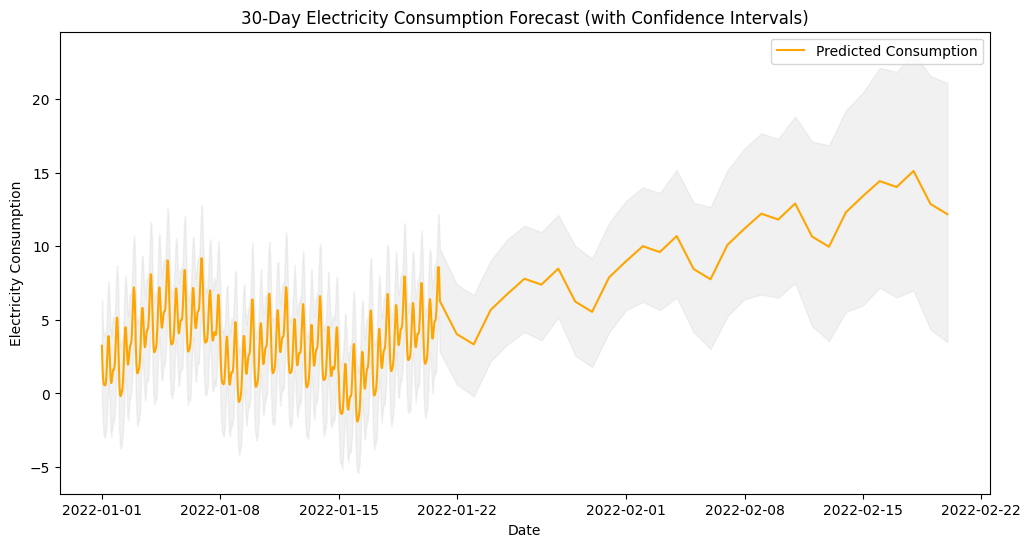

In [12]:
import pandas as pd

# Load the data
data = pd.read_csv('NYC_Energy_Consumption.csv')

# Display first few rows to understand the structure
print(data.head())

# Convert 'TxnDate' to datetime format and create a new datetime column 'ds'
data['ds'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'], format='%d %b %Y %H:%M:%S')
data['y'] = data['Consumption']

# Drop the original 'TxnDate' and 'TxnTime' columns if they are no longer needed
data = data[['ds', 'y']]

# Check the updated DataFrame
print(data.head())

# Drop the original 'TxnDate' and 'TxnTime' columns if they are no longer needed
data = data[['ds', 'y']]

# Check the updated DataFrame
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Extract additional time-related features: weekday/weekend
data['Weekday'] = data['ds'].dt.weekday
data['Weekend'] = data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Adding a simple holiday feature (update this list as needed)
holidays = {
    '2022-01-01',  # New Year's Day
    '2022-07-04',  # Independence Day
    '2022-12-25',  # Christmas
}

# Create a binary holiday column
data['Holiday'] = data['ds'].dt.date.isin(holidays).astype(int)

# Prepare for time-series forecasting with Prophet
model = Prophet()

# Adding additional regressors
model.add_regressor('Weekend')
model.add_regressor('Holiday')

# Fit the model on the historical data
model.fit(data)

# Make future predictions for the next 30 days
future = model.make_future_dataframe(periods=30, freq='D')

# Add the same external regressors to the future data
future['Weekend'] = future['ds'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
future['Holiday'] = future['ds'].dt.date.isin(holidays).astype(int)

# Predict future consumption
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast)
plt.title("Electricity Consumption Forecast for New York")
plt.show()

# Evaluate Model Performance
# Split data for model evaluation (train-test split)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Create a new Prophet model for the training data
model_eval = Prophet()

# Adding additional regressors for the evaluation model
model_eval.add_regressor('Weekend')
model_eval.add_regressor('Holiday')

# Fit the model on the training data
model_eval.fit(train_data)

# Prepare the test data for predictions
test_data['Weekend'] = test_data['ds'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
test_data['Holiday'] = test_data['ds'].dt.date.isin(holidays).astype(int)

# Make predictions on the test data
test_forecast = model_eval.predict(test_data)

# Evaluate performance using MAE and MSE
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual Consumption', color='blue')
plt.plot(test_data['ds'], test_forecast['yhat'], label='Predicted Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Actual vs Predicted Electricity Consumption')
plt.legend()
plt.show()

# Print and visualize the forecasted consumption for the next 30 days
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

# Plot the forecasted consumption
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Consumption', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgray', alpha=0.3)
plt.title('30-Day Electricity Consumption Forecast (with Confidence Intervals)')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

In [13]:
pip install pandas matplotlib statsmodels

In [14]:


# Load the data
data = pd.read_csv('NYC_Energy_Consumption.csv')

# Convert 'TxnDate' to datetime format and create a new datetime column 'ds'
data['ds'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'], format='%d %b %Y %H:%M:%S')
data['y'] = data['Consumption']

# Drop unnecessary columns
data = data[['ds', 'y']]

# Set 'ds' as the index
data.set_index('ds', inplace=True)

# Check for duplicates and handle them by averaging
if data.index.duplicated().any():
    print("Duplicate indices found. Aggregating by mean.")
    data = data.groupby(data.index).mean()

# Set frequency (use 'h' for hourly, 'd' for daily, etc.)
data = data.asfreq('h')  # Change 'h' according to your data frequency

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Check for NaN values in the training data
if train_data.isnull().any().any():
    print("NaN values found in training data. Dropping NaNs.")
    train_data = train_data.dropna()

# ARIMA Model
try:
    # Fit ARIMA model (p, d, q)
    arima_model = ARIMA(train_data, order=(2, 1, 2))  # Adjust (p, d, q) to lower values if needed
    arima_fit = arima_model.fit()

    # Forecasting ARIMA
    arima_forecast = arima_fit.forecast(steps=len(test_data))

    # Create a DataFrame for predictions with the correct index
    forecast_index = test_data.index
    arima_forecast = pd.Series(arima_forecast, index=forecast_index)

    # Ensure we fill NaN values if any still exist
    if arima_forecast.isnull().any():
        print("NaN values found in ARIMA predictions. Filling NaNs with the mean of predictions.")
        arima_forecast.fillna(arima_forecast.mean(), inplace=True)

    # Add predictions to test_data
    test_data['ARIMA_Prediction'] = arima_forecast

    # Evaluation for ARIMA
    mae_arima = mean_absolute_error(test_data['y'], test_data['ARIMA_Prediction'])
    mse_arima = mean_squared_error(test_data['y'], test_data['ARIMA_Prediction'])

    print(f'ARIMA Mean Absolute Error: {mae_arima}')
    print(f'ARIMA Mean Squared Error: {mse_arima}')

    # Plot ARIMA predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data['y'], label='Actual Consumption', color='blue')
    plt.plot(test_data.index, test_data['ARIMA_Prediction'], label='ARIMA Prediction', color='red')
    plt.title('ARIMA Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Electricity Consumption')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

Duplicate indices found. Aggregating by mean.
NaN values found in training data. Dropping NaNs.
NaN values found in ARIMA predictions. Filling NaNs with the mean of predictions.
An error occurred: Input contains NaN.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


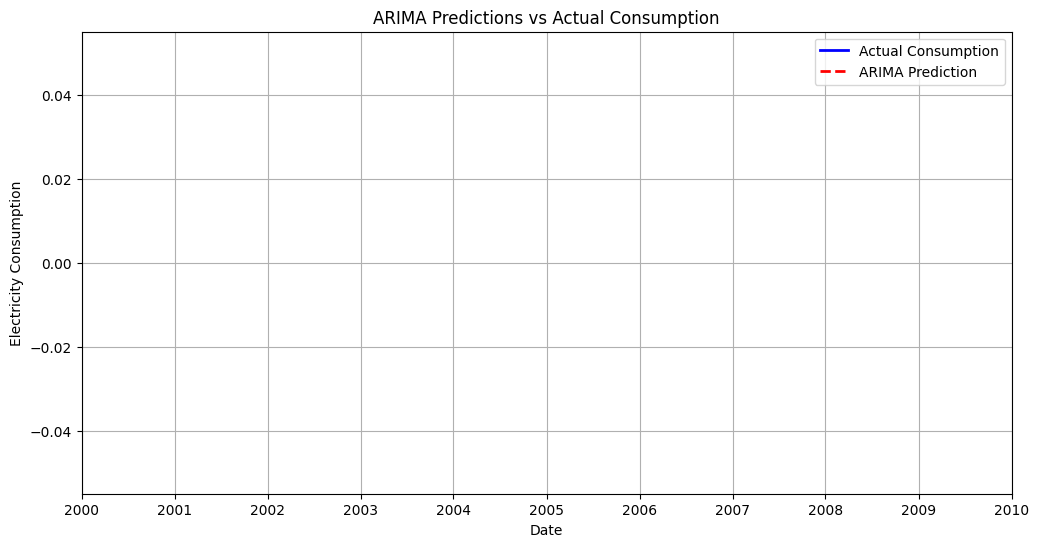

In [15]:
import matplotlib.pyplot as plt

# Plot ARIMA predictions vs Actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['y'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(test_data.index, test_data['ARIMA_Prediction'], label='ARIMA Prediction', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA Predictions vs Actual Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid()
plt.show()

NaN values found in ARIMA predictions. Filling NaNs with the mean of predictions.
NaN values found in actual data. Filling NaNs with the mean of actual values.
NaN values found in residuals. Dropping NaNs.


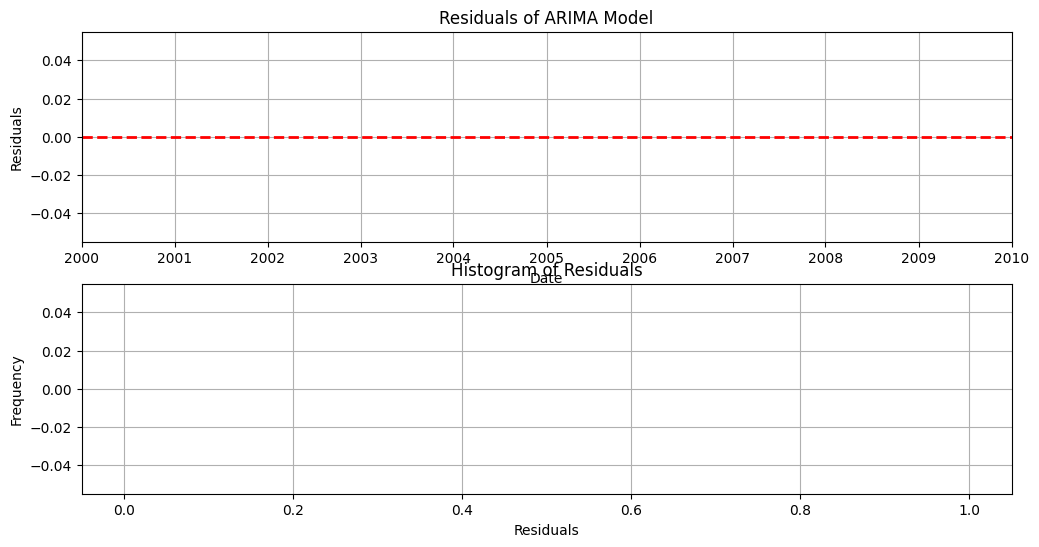

In [16]:
# After forecasting and before calculating residuals

# Check for NaN values in predictions and fill them
if test_data['ARIMA_Prediction'].isnull().any():
    print("NaN values found in ARIMA predictions. Filling NaNs with the mean of predictions.")
    test_data['ARIMA_Prediction'] = test_data['ARIMA_Prediction'].fillna(test_data['ARIMA_Prediction'].mean())

# Check for NaN values in actual data and fill them
if test_data['y'].isnull().any():
    print("NaN values found in actual data. Filling NaNs with the mean of actual values.")
    test_data['y'] = test_data['y'].fillna(test_data['y'].mean())

# Calculate residuals
residuals = test_data['y'] - test_data['ARIMA_Prediction']

# Check for NaN values in residuals and drop them
if residuals.isnull().any():
    print("NaN values found in residuals. Dropping NaNs.")
    residuals = residuals.dropna()

# Ensure the test_data DataFrame is also filtered to match residuals
test_data = test_data.loc[residuals.index]

# Proceed with plotting the residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(test_data.index, residuals, color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid()

# Histogram of residuals
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30, color='gray')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [17]:
print("Shape of test_data:", test_data.shape)
print("Shape of actual values (y):", test_data['y'].shape)
print("Shape of predicted values (ARIMA_Prediction):", test_data['ARIMA_Prediction'].shape)
print("Shape of residuals:", residuals.shape)

Shape of test_data: (0, 2)
Shape of actual values (y): (0,)
Shape of predicted values (ARIMA_Prediction): (0,)
Shape of residuals: (0,)


Duplicate indices found. Aggregating by mean.


<ipython-input-18-a8349bc1980c>:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.asfreq('H')  # Adjust frequency as needed
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Mean Absolute Error: 0.0
SARIMA Mean Squared Error: 0.0


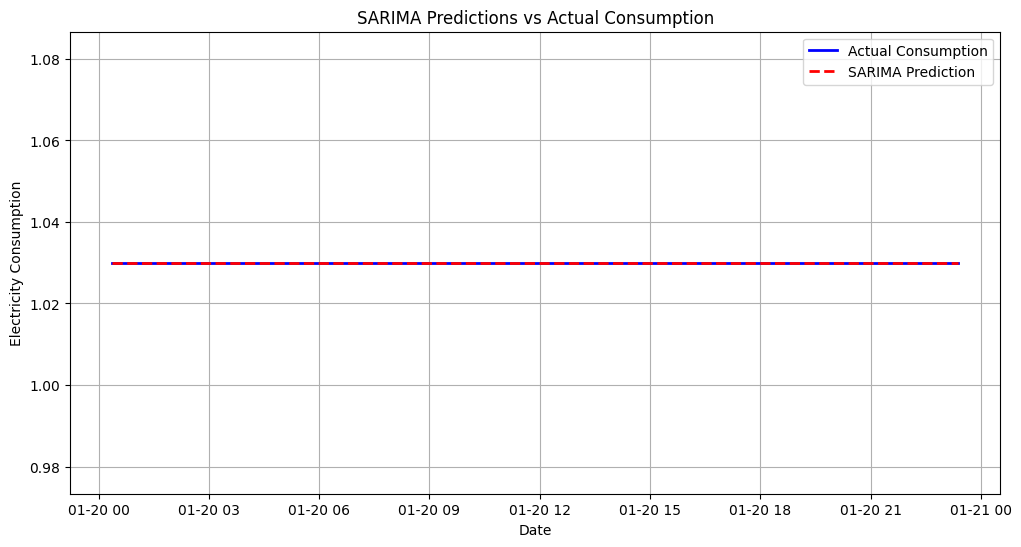

In [18]:


# Load the data
data = pd.read_csv('NYC_Energy_Consumption.csv')

# Convert 'TxnDate' to datetime and create a new datetime index
data['ds'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'], format='%d %b %Y %H:%M:%S')
data['y'] = data['Consumption']
data = data[['ds', 'y']]

# Set 'ds' as the index
data.set_index('ds', inplace=True)

# Check for duplicates and handle them if necessary
if data.index.duplicated().any():
    print("Duplicate indices found. Aggregating by mean.")
    data = data.groupby(data.index).mean()

# Set frequency (e.g., 'H' for hourly)
data = data.asfreq('H')  # Adjust frequency as needed

# Fill NaN values (if any)
data['y'] = data['y'].fillna(data['y'].mean())

# Split the data into training and testing sets
train_data = data[:-24]  # Last 24 hours for testing
test_data = data[-24:]

# Fit the SARIMA model (p, d, q) x (P, D, Q, S)
# Example: (1, 1, 1) x (1, 1, 1, 24) for hourly data with a daily seasonality
sarima_model = SARIMAX(train_data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit(disp=False)

# Forecasting
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# Create a DataFrame for predictions with the correct index
sarima_forecast = pd.Series(sarima_forecast, index=test_data.index)

# Evaluation
mae_sarima = mean_absolute_error(test_data['y'], sarima_forecast)
mse_sarima = mean_squared_error(test_data['y'], sarima_forecast)

print(f'SARIMA Mean Absolute Error: {mae_sarima}')
print(f'SARIMA Mean Squared Error: {mse_sarima}')

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['y'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Prediction', color='red', linestyle='--', linewidth=2)
plt.title('SARIMA Predictions vs Actual Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid()
plt.show()